<a href="https://colab.research.google.com/github/NaomiInbal/anomaly-detection-and-trajectory-classification/blob/missile_trajectories_for_final_report/creating_missile_trajectories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Welcome to Missile Trajectory Physical Model Simulation!
###Note: Running the simulator to create new data takes about 15 minutes.
###You can see and download the existing data at this link:
 https://drive.google.com/drive/folders/1vsQ1DBiNDY6Ene-2mJa-0BbeGeTBWpT4?usp=drive_link

 When running the code, a window will appear and you will be asked to confirm the creation of the folder of the data(in google drive storage), and after confirmation, the data will be created.

# Missile Trajectory Physical Model Simulation
In this section we will create a missile trajectory physical simulation. To do so, we'll define the necessary equations we need in order to proceed with this process:

(1)
$$
F⃗_{net}=F⃗_{Thrust} - F⃗_{Drag} - F⃗_g
$$

(2)
$$
m\cdot \frac{d^2z}{dt^2} = F⃗_{Thrust}(t) - F⃗_{Drag}(z,{ż}^2) - F⃗_g(z,t)
$$




*Net force is the sum of all forces acting on an object. The net force can be calculated using Newton's second law, which states that F = ma
F Thrust - דחף המנוע
F Drag - כוח גרר (חיכוך) https://en.wikipedia.org/wiki/Drag_(physics)

The equations given above defines an elementary physical model, based on Newton's 2nd Law (1),(F = m*a) i.e., the net force applied by the missile is proportional to the force applied by the engine's thrust, reducing the drag of the missile and the force of gravity.
One thing we have to take in account is that the different componenets in eq #1 are dependent of each other, forcing us to take a differential approach to solve it.

##Assumptions


1. Most rockets reaching orbit are liquid-fueled, except for the Space Shuttle.
In this project, we assume constant thrust during ascent, with thrust depending only on time. The model acknowledges its one-dimensional nature, simplifying the vertical thrust component and accounting for potential aerodynamic lift in non-zero angle launches.

2. The rocket experiences drag from atmospheric and wave components. Atmospheric drag, a form of parasitic drag, opposes motion due to skin friction. The equation for atmospheric skin friction drag is expressed with air density (ρ), rocket velocity (v), drag coefficient (CD), and cross-sectional area (A). Assuming CD = 0.75, representing a shape between a cylinder and a cone. Air density calculation involves the ideal gas law for altitudes under 86 km, considering gas constant (R), and molar mass of air (M). Atmospheric temperature and pressure, dependent on altitude, are determined by barometric equations.

3.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import zipfile
import pandas as pd
from google.colab import drive


## Physical Universal Constants



In [22]:
# Universal constants
G = 6.674e-11  # gravitational constant
M_earth = 5.972e24  # mass of the Earth
r = 6371000 # radius of the Earth in meters
mol = 0.029  # molar mass of air
R = 8.314  # gas constant
P0 = 101325  # standard pressure (Pa), sea level
T0 = 300  # Israel temperature (K), sea level
rho0 = (mol * P0) / (R * T0)  # air density, sea level
g0 = 9.81  # gravitational acceleration, sea level


## Local Constants

In [23]:
# Local constants

FT = 560000  # rocket thrust, in Newtons
d = 1.7  # rocket diameter, in meters
A = np.pi * (d / 2) ** 2  # rocket cross-sectional area
L = 0  # rocket length, in meters
empty = 3120  # mass when fuel is expended, in kg ("dry mass")
Isp = 221  # specific impulse, in seconds
dm = FT / (g0 * Isp)  # mass flow rate, dm/dt


# Initial Conditions
m0 = 46760  # initial mass, in kg ("wet mass")
C0 = 0.75  # drag coefficient
z0 = 1  # initial altitude
v0 = 0  # initial velocity


# Euler-Cromer Method
dt = 0.1  # time step

v = v0
z = z0
V = [v]
Z = [z]
m = m0
Rho = [rho0]
T = [T0]
P = [P0]
M = [m]
Thrust = [FT / m]
Drag = [0]
g = g0
grav = [g]

nextstage = 0
tmax = 500

# Define auxiliary functions
The following functions will help us simulate the environmental changes as a function of the height.



In order to simulate the changes in temperature as a function of given height, we used the following table:
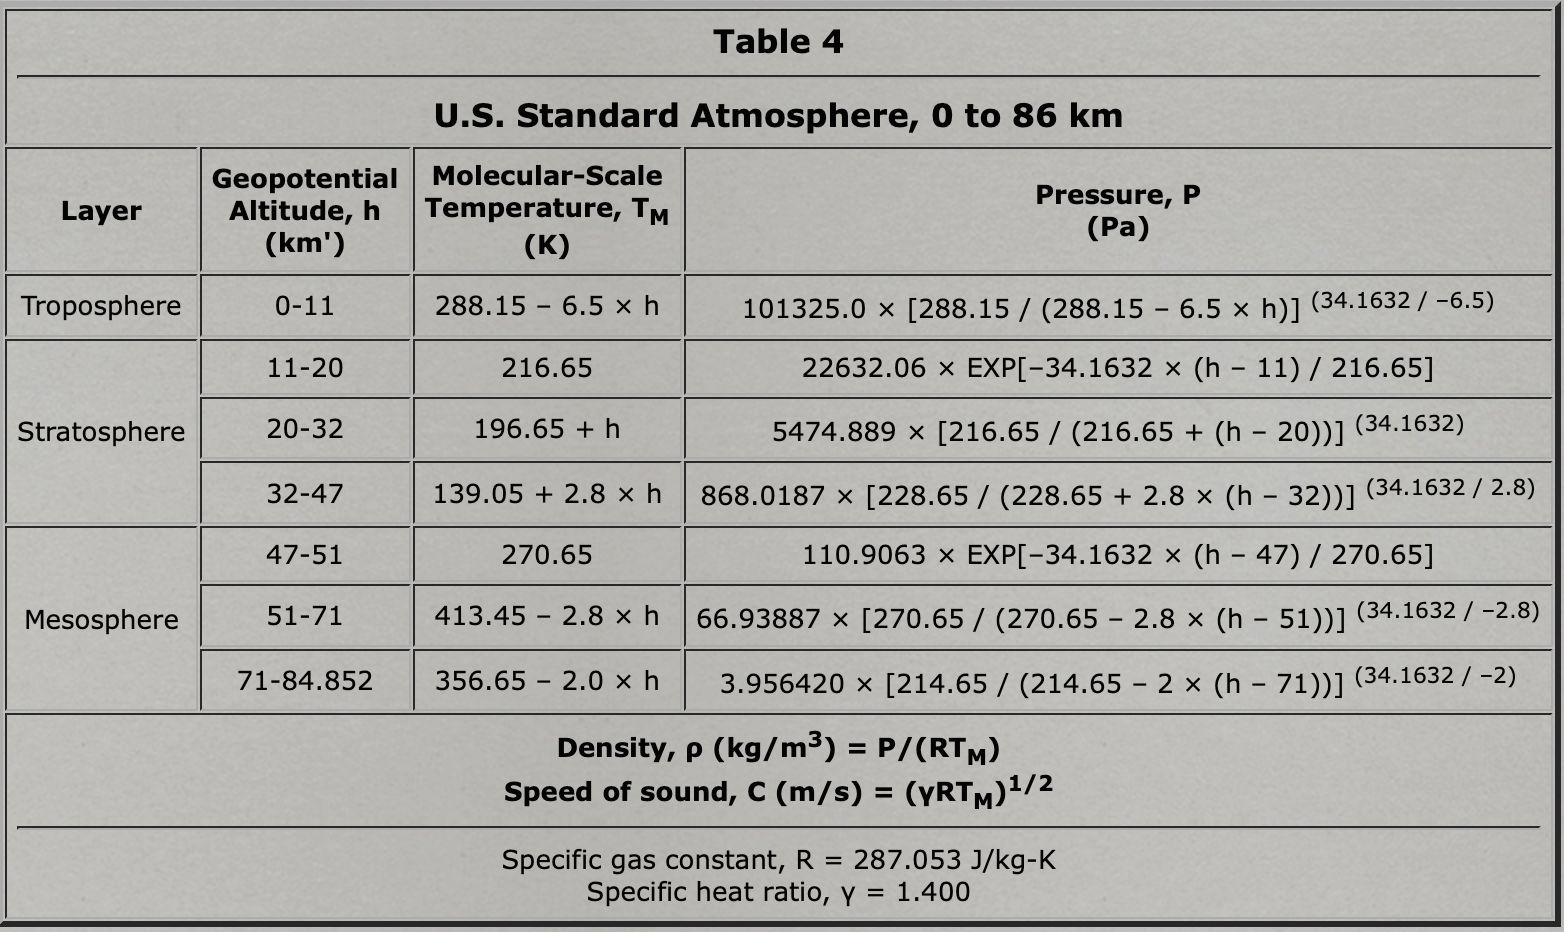

The provided Python implementation is applying the Prandtl-Glauert rule, which is often used to correct the drag coefficient $C_d$ values for subsonic flow when approaching or reaching the speed of sound $Mach = 1$. This rule is an approximation and is valid for \(Mach < 1\).

The formula implemented in the code is:
$$
C_d = \frac{C_0}{\sqrt{1 - Mach^2}}
$$
where:


- $C_d$ is the corrected drag coefficient,
- $C_0$ is the drag coefficient at zero velocity (assumed constant, not defined in the provided code),
- $Mach$ is the Mach number.

This formula essentially adjusts the drag coefficient as the rocket approaches the speed of sound to account for the compressibility effects on aerodynamics.

However, it's crucial to note that this correction is specific to subsonic flows. For supersonic or transonic flows $Mach > 1$, different formulations and considerations are needed.



In [24]:
meter_to_km = lambda z: z/1000


def gaussian_noise(*args, noise_factor=0.01):
    """
    Add proportional noise to each input parameter.

    Parameters:
    - args: Arbitrary number of float parameters.
    - noise_factor (float): Scaling factor for the noise.

    Returns:
    - list: List of parameters with added proportional noise.
    """
    noisy_parameters = [param * (1 + noise_factor * np.random.randn()) for param in args]
    return noisy_parameters


# Define density function
def density(z):
    """
    Calculate air density, temperature, and pressure at a given altitude using the barometric formula.

    Parameters:
    - z (float): Altitude in meters.

    Returns:
    - density (float): Air density in kg/m^3.
    - temperature (float): Temperature in Kelvin.
    - pressure (float): Pressure in Pascal.
    """

    h = meter_to_km(z)

    if   0 <= h <= 11:
        temperature = 288.15 - 6.5 * h
        pressure = 101325 * ((288.15 / (288.15 - 6.5 * h)) ** (34.1632 / -6.5))

    elif 11 < h <= 20:
        temperature = 216.65
        pressure = 22632.06 * np.exp(-34.1632 * (h - 11) / 216.65)

    elif 20 < h <= 32:
        temperature = 196.65 + 0.001 * z
        pressure = 5474.889 * ((216.65 / (216.65 + (h - 20))) ** (34.1632))

    elif 32 < h <= 47:
        temperature = 139.05 + 2.8 * h
        pressure = 868.0187 * ((228.65 / (228.65 + 2.8 * (h - 32))) ** (34.1632 / 2.8))

    elif 47 < h <= 51:
        temperature = 270.65
        pressure = 110.9063 * np.exp(-34.1632 * (h - 47) / 270.65)

    elif 51 < h <= 71:
        temperature = 413.45 - 2.8 * h
        pressure = 66.93887 * ((270.65 / (270.65 - 2.8 * (h - 51))) ** (34.1632 / -2.8))

    else:
        temperature = 356.65 - 2.0 * h
        pressure = 3.956420 * (abs(214.65 / (214.65 - 2 * h) ) ** (34.1632 / -2))

    density = (mol * pressure) / (R * temperature)

    if 86 < h <= 91:
        pressure = np.exp(-4.22012E-08 * h ** 5 + 2.13489E-05 * h ** 4 - 4.26388E-03 * h ** 3 +
                           0.421404 * h ** 2 - 20.8270 * h + 416.225)
        density = np.exp(7.5691E-08 * h ** 5 - 3.76113E-05 * h ** 4 + 0.0074765 * h ** 3 -
                         0.743012 * h ** 2 + 36.7280 * h - 729.346)
        temperature = 186.8673
    elif 91 < h <= 100:
        pressure = np.exp(-4.22012E-08 * h ** 5 + 2.13489E-05 * h ** 4 - 4.26388E-03 * h ** 3 +
                           0.421404 * h ** 2 - 20.8270 * h + 416.225)
        density = np.exp(7.5691E-08 * h ** 5 - 3.76113E-05 * h ** 4 + 0.0074765 * h ** 3 -
                         0.743012 * h ** 2 + 36.7280 * h - 729.346)
        temperature = 263.1905 - 76.3232 * np.sqrt(1 - ((h - 91) / -19.9429) ** 2)
    elif 100 < h <= 110:

        pressure = np.exp(-4.22012E-08 * h ** 5 + 2.13489E-05 * h ** 4 - 4.26388E-03 * h ** 3 +
                           0.421404 * h ** 2 - 20.8270 * h + 416.225)
        density = np.exp(7.5691E-08 * h ** 5 - 3.76113E-05 * h ** 4 + 0.0074765 * h ** 3 -
                         0.743012 * h ** 2 + 36.7280 * h - 729.346)
        temperature = 263.1905 - 76.3232 * np.sqrt(1 - ((h - 91) / -19.9429) ** 2)
    elif 110 < h <= 120:
        density = np.exp(-8.854164E-05 * h ** 3 + 0.03373254 * h ** 2 - 4.390837 * h +
                          176.5294)
        pressure = 0
        temperature = 240 + 12 * (h - 110)
    elif 120 < h <= 150:
        pressure = 0
        density = np.exp(3.661771E-07 * h ** 4 - 2.154344E-04 * h ** 3 + 0.04809214 * h ** 2 -
                         4.884744 * h + 172.3597)
        temperature = 1000 - 640 * np.exp(-0.01875 * (h - 120) * (6356.766 + 120) / (6356.766 + h))
    elif 150 < h:  # && h <= 200
        pressure = 0
        density = 2.0763e-09
        temperature = 1000 - 640 * np.exp(-0.01875 * (h - 120) * (6356.766 + 120) / (6356.766 + h))
    return density, temperature, pressure


# Define Drag Coefficient Function
def drag_coefficient(velocity, temp):
    Cd = 0.0  # Initialize Cd before the conditional statements
    cs = np.sqrt(1.4 * 287 * temp)  # sound speed as a function of temperature
    Mach = velocity / cs  # Mach number
    if Mach < 1:
        Cd = C0 / np.sqrt(1 - Mach ** 2)  # Prandtl-Glauert Rule
    elif Mach == 1:
        Mach = 0.99999  # eliminate the singularity
        Cd = C0 / np.sqrt(1 - Mach ** 2)
    elif Mach > 1:
        Cd = C0 / np.sqrt(Mach ** 2 - 1)
    return Cd

# Save the data


In [25]:
def create_drive_folder(folder_name):
    """
    Create a new folder in Google Drive.

    Parameters:
    - folder_name (str): Name of the new folder.

    Returns:
    None
    """
    # Mount Google Drive
    #drive.mount('/content/gdrive')
    drive.mount("/content/gdrive", force_remount=True)

    # Define the path to the new folder
    drive_folder_path = os.path.join('/content/gdrive/My Drive', folder_name)

    # Check if the folder already exists
    if not os.path.exists(drive_folder_path):
        # Create the new folder
        os.makedirs(drive_folder_path)
        print(f"Folder '{folder_name}' created in Google Drive.")
        return drive_folder_path
    else:
        print(f"Folder '{folder_name}' already exists in Google Drive.")
        return drive_folder_path
dataset_path = create_drive_folder('missile_data')

Mounted at /content/gdrive
Folder 'missile_data' already exists in Google Drive.


In [26]:
import os
import pandas as pd

def save_data_to_csv(data, file_name, data_dir_path):
    """
    Save the provided data dictionary to a CSV file within the missile_data folder.

    Parameters:
    - data (dict): Dictionary containing data.
    - file_name (str): Name of the CSV file.
    - dataset_dir (str): Directory where the missile_data folder is located.

    Returns:
    None
    """
    # Combine the directory path with the file name
    file_path = os.path.join(data_dir_path, file_name)
    df = pd.DataFrame(data)

    # Save DataFrame as CSV
    df.to_csv(file_path, index=False)


In [27]:
def zip_and_transfer(folder_path, zip_file_name, destination_folder):
    """
    Create a zip file containing all existing files in the given folder
    and transfer it to a new destination folder.

    Parameters:
    - folder_path (str): Path to the folder containing files to be zipped.
    - zip_file_name (str): Name of the zip file to be created.
    - destination_folder (str): Path to the folder where the zip file will be transferred.

    Returns:
    None
    """
    zip_file_path = os.path.join(destination_folder, zip_file_name)

    with zipfile.ZipFile(zip_file_path, 'w') as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname=arcname)

In [28]:
def plot_graphs(tmax, dt, V, Z, M, Thrust, grav, Rho, T, P, Drag):
    """
    Plot various aspects of a missile's trajectory and forces over time.

    Parameters:
    - tmax (float): Maximum time of the simulation.
    - dt (float): Time step for the simulation.
    - V (numpy.ndarray): Array containing missile velocities at each time step.
    - Z (numpy.ndarray): Array containing missile altitudes at each time step.
    - M (numpy.ndarray): Array containing missile masses at each time step.
    - Thrust (numpy.ndarray): Array containing thrust forces at each time step.
    - grav (numpy.ndarray): Array containing gravitational accelerations at each time step.
    - Rho (numpy.ndarray): Array containing air densities at each time step.
    - T (numpy.ndarray): Array containing temperatures at each time step.
    - P (numpy.ndarray): Array containing pressures at each time step.
    - Drag (numpy.ndarray): Array containing drag forces at each time step.


    Plots:
    1. Missile altitude over time.
    2. Missile velocity over time.
    3. Thrust and drag forces over time.
    4. Gravitational acceleration over time.
    """

    # Create time array
    t = np.arange(0, tmax + dt, dt)

    # Plot the trajectory, forces, and density
    fig, axes = plt.subplots(4, 1, figsize=(10, 12))

    # Plot the trajectory (altitude)
    axes[0].plot(t, np.array(Z) / 1000)  # Divided by 1000 to plot in kilometers
    axes[0].set_title('Rocket altitude')
    axes[0].set_ylim([0, 1.5 * max(Z) / 1000])  # Adjust y-axis limits
    axes[0].set_xlabel('time (s)')
    axes[0].set_ylabel('altitude (km)')

    # Plot the velocity
    axes[1].plot(t, V)
    axes[1].set_title('Rocket velocity')
    axes[1].set_ylim([1.5 * min(V), 1.5 * max(V)])  # Adjust y-axis limits
    axes[1].set_xlabel('time (s)')
    axes[1].set_ylabel('velocity (m/s)')

    # Plot the forces (Thrust and Drag)
    axes[2].plot(t, np.array(Thrust) * (np.array(M)), label='Thrust')
    axes[2].plot(t, np.array(Drag) * np.array(M), label='Drag')
    axes[2].set_title('Thrust and Drag forces')
    axes[2].set_xlabel('time (s)')
    axes[2].set_ylabel('force (kN)')
    axes[2].legend()

    # Plot the gravitational acceleration
    axes[3].plot(t, grav)
    axes[3].set_title('Gravitational acceleration')
    axes[3].set_xlabel('time (s)')
    axes[3].set_ylabel('g (m/s^2)')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    plt.show()



## Trajectory Simulator
### Generating normal trajectories and plot the graphs of an example of a normal missile trajectory

Starts by creating normal missile trajectories and saving them in a folder in Google Drive...
    This is going to take a while....
All datasets saved successfully.


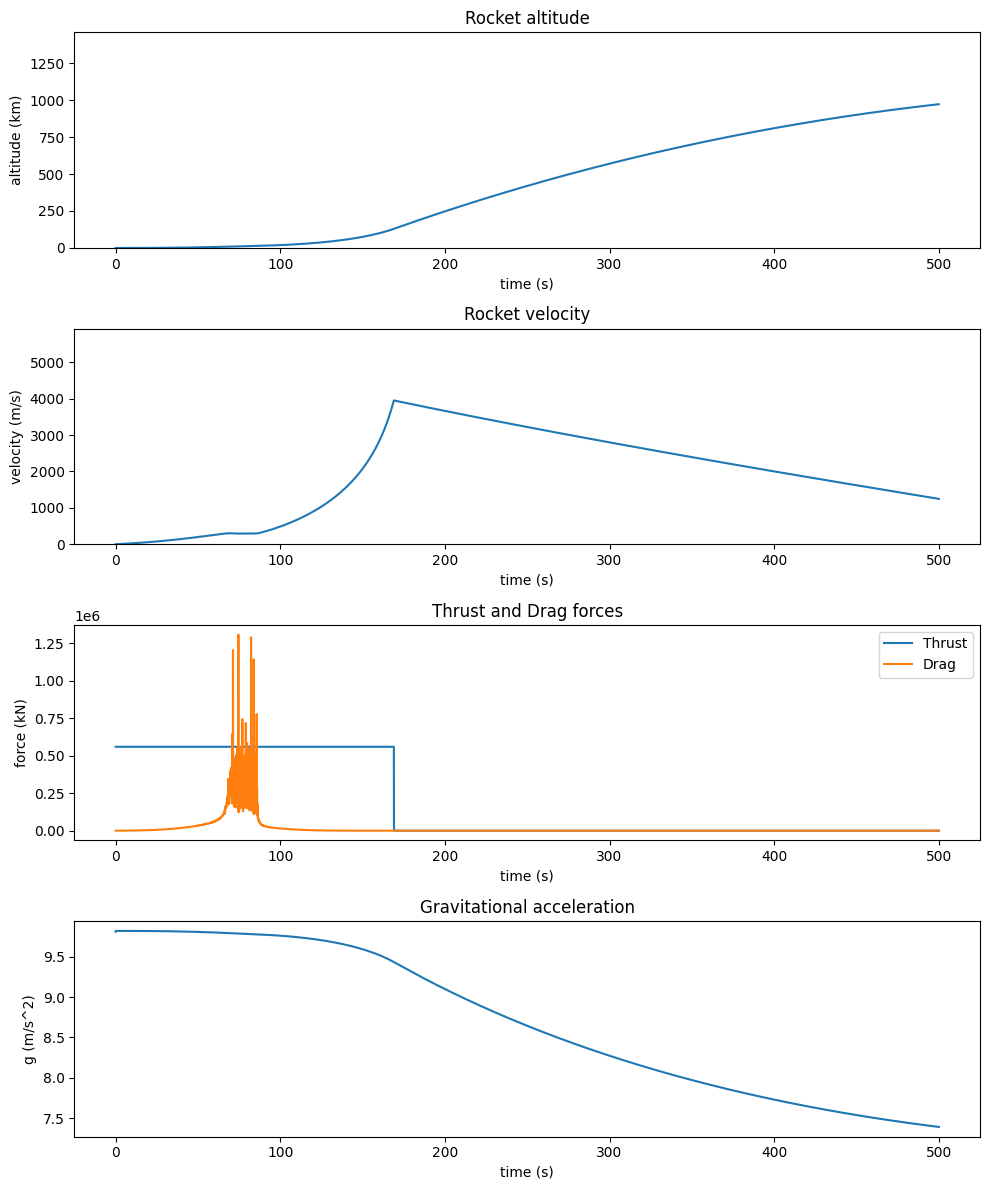

In [32]:
def generating_normal_trajectories(num_samples=2000):
    """
    Simulate rocket launches with varying parameters and save the data to CSV files.

    Parameters:
    - num_samples (int): Number of rocket launch simulations to perform.

    Returns:
    - None

    Simulation Parameters:
    - FT (float): Rocket thrust in Newtons.
    - d (float): Rocket diameter in meters.
    - A (float): Rocket cross-sectional area calculated from the diameter.
    - L (float): Rocket length in meters (currently set to 0, no effect in the simulation).
    - empty (float): Mass when fuel is expended (dry mass) in kg.
    - Isp (float): Specific impulse in seconds.
    - dm (float): Mass flow rate calculated from thrust and specific impulse.
    - m0 (float): Initial mass (wet mass) of the rocket in kg.
    - C0 (float): Drag coefficient (currently set to 0.75, can be modified).
    - z0 (float): Initial altitude of the rocket.
    - v0 (float): Initial velocity of the rocket.
    - dt (float): Time step for the simulation.

    Outputs:
    - CSV files containing simulation data for each sample. Each CSV file includes columns:
      - Velocity[m/s], Altitude[m], Thrust[N], Gravitational Acceleration[m/s^2],
      - Temperature[K], Pressure[PSI], Drag[N], Mass[Kg], Density, Label.


    - The simulation uses the Euler-Cromer method for numerical integration.
    - Air density and drag coefficient are subject to Gaussian noise.
    - Rocket parameters can be modified for different scenarios.


    """
    print("""Starts by creating normal missile trajectories and saving them in a folder in Google Drive...
    This is going to take a while....""")

    for i in range(num_samples):
        # TODO: Consider making these variables non-deterministic
        FT = 560000  # rocket thrust, in Newtons
        d = 1.7  # rocket diameter, in meters
        A = np.pi * (d / 2) ** 2  # rocket cross-sectional area
        L = 0  # rocket length, in meters
        empty = 3120  # mass when fuel is expended, in kg ("dry mass")
        Isp = 221  # specific impulse, in seconds
        dm = FT / (g0 * Isp)  # mass flow rate, dm/dt


        # Initial Conditions
        m0 = 46760  # initial mass, in kg ("wet mass")
        C0 = 0.75  # drag coefficient, see notes
        z0 = 1  # initial altitude
        v0 = 0  # initial velocity


        # Euler-Cromer Method
        dt = 0.1  # time step

        v = v0
        z = z0
        V = [v]
        Z = [z]
        m = m0
        Rho = [rho0]
        T = [T0]
        P = [P0]
        M = [m]
        Thrust = [FT / m]
        Drag = [0]
        g = g0
        grav = [g]

        nextstage = 0
        tmax = 500


        for t in np.arange(dt, tmax + dt, dt):
            g = (G * M_earth) / ((z + 6371000) ** 2)  # gravitational acceleration, g(z)
            m = m - (dm * dt)  # changing mass, m(t)
            rho, temp, press = density(z)
            rho, temp, press = gaussian_noise(rho, temp, press)

            # changing air density by barometric formula, rho(z)
            Cd = gaussian_noise(drag_coefficient(v, temp))[0]

            thrust = FT / m
            drag = 0.5 * rho * (v ** 2) * Cd * A / m

            if v < 0:  # flip drag force vector if rocket falls
                drag = drag * -1

            v = v + (thrust - drag - g) * dt  # new velocity
            z = z + v * dt  # new altitude

            V.append(v)
            Z.append(z)
            M.append(m)
            grav.append(g)
            Thrust.append(thrust)
            Drag.append(drag)
            Rho.append(rho)
            T.append(temp)
            P.append(press)


            if z < 0:  # rocket crashes or fails to launch
                break
            elif m < empty:  # rocket runs out of fuel, mass becomes stable
                FT = 0
                dm = 0
                nextstage += 1
        data = {
        'Velocity[m/s]': V,
        'Altitude[m]': Z,
        'Thrust[N]': Thrust,
        'gravitation [m/s^2]': grav,
        'Temperature[K]': T,
        'Pressure[PSI]': P,
        'Drag[N]': Drag,
        'Mass[Kg]': M,
        'Density': Rho,
        'Label': 0
        }

        data_dir_path = "/content/gdrive/My Drive/missile_data"
        success = True  # Flag to track if all data saving operations succeeded
        try:
            save_data_to_csv(data, f"{i}.csv", data_dir_path)
        except Exception as e:
            success = False
    if success:
        print(f"All datasets saved successfully.")
    else:
        print("Some datasets failed to save.")
    plot_graphs(tmax, dt, V, Z, M, Thrust, grav, Rho, T, P, Drag)
generating_normal_trajectories(num_samples=2000)


###Generating corrupted, noisy, anomaly samples and plot the graphs of an example of a noisy samples




Starts by creating anomaly missile trajectories and saving them in a folder in Google Drive...
    This is going to take a while....
All datasets saved successfully.


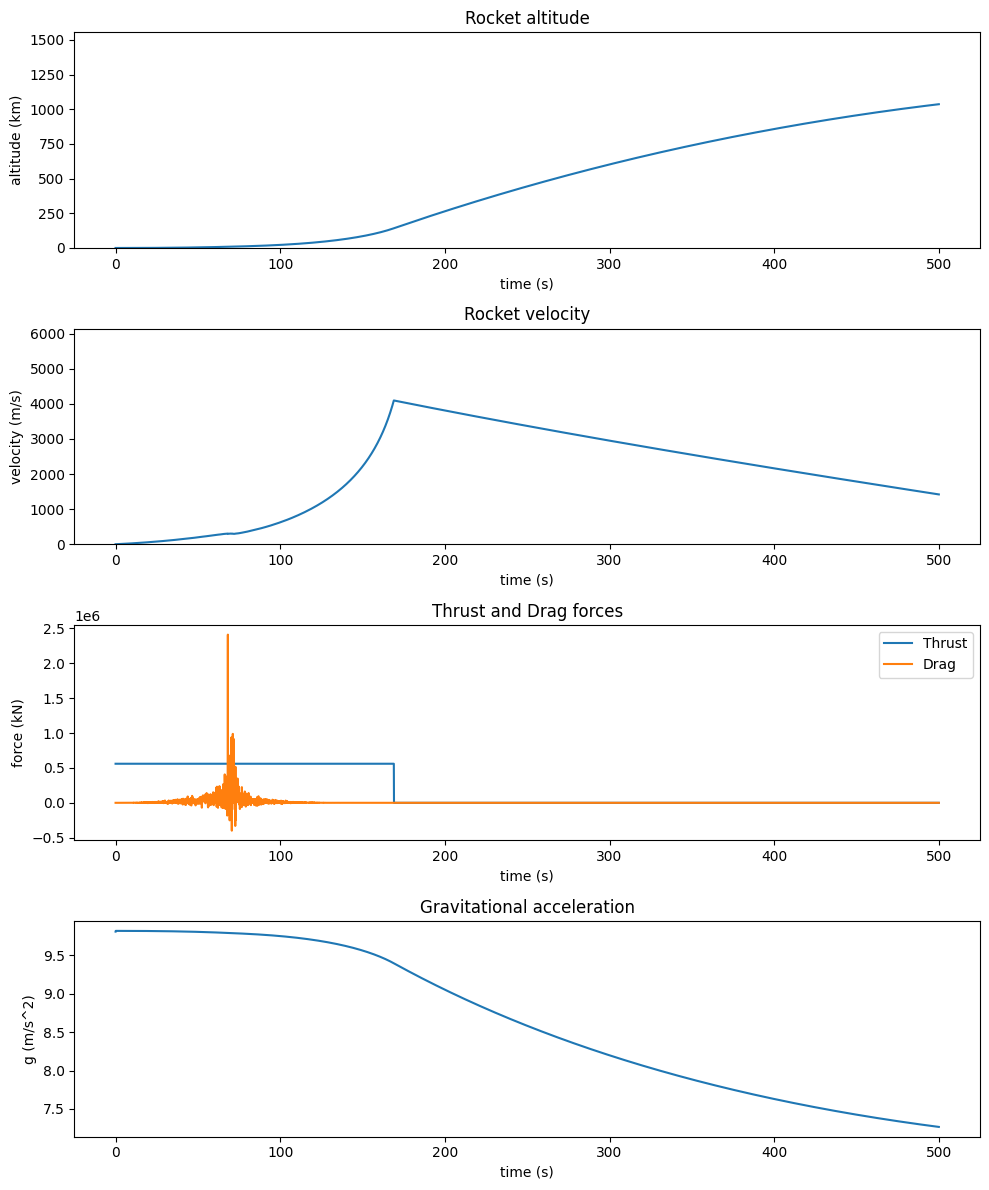

In [33]:
def generating_anomaly_samples(num_samples = 500):

    """
    This function generating same trajectory as the first function does, but with diffrent:
    It creates anomaly samples by gaussian_noise and set the noise_factor to 0.98
    """
    print("""Starts by creating anomaly missile trajectories and saving them in a folder in Google Drive...
    This is going to take a while....""")

    for i in range(num_samples):
      FT = 560000  # rocket thrust, in Newtons
      d = 1.7  # rocket diameter, in meters
      A = np.pi * (d / 2) ** 2  # rocket cross-sectional area
      L = 0  # rocket length, in meters
      empty = 3120  # mass when fuel is expended, in kg ("dry mass")
      Isp = 221  # specific impulse, in seconds
      dm = FT / (g0 * Isp)  # mass flow rate, dm/dt

      # Initial Conditions
      m0 = 46760  # initial mass, in kg ("wet mass")
      C0 = 0.75  # drag coefficient
      z0 = 1  # initial altitude
      v0 = 0  # initial velocity

      # Euler-Cromer Method
      dt = 0.1  # time step

      v = v0
      z = z0
      V = [v]
      Z = [z]
      m = m0
      Rho = [rho0]
      T = [T0]
      P = [P0]
      M = [m]
      Thrust = [FT / m]
      Drag = [0]
      g = g0
      grav = [g]

      nextstage = 0
      tmax = 500

      for t in np.arange(dt, tmax + dt, dt):
          g = (G * M_earth) / ((z + r) ** 2)  # gravitational acceleration, g(z)
          m = m - (dm * dt)  # changing mass, m(t)
          rho, temp, press = density(z)
          rho, temp, press = gaussian_noise(rho, temp, press)

          # changing air density by barometric formula, rho(z)
          Cd = gaussian_noise(drag_coefficient(v, temp), noise_factor=0.98)[0]  # Drag coefficient.

          thrust = FT / m
          drag = 0.5 * rho * (v ** 2) * Cd * A / m

          if v < 0:  # flip drag force vector if rocket falls
              drag = drag * -1

          v = v + (thrust - drag - g) * dt  # new velocity
          z = z + v * dt  # new altitude

          V.append(v)
          Z.append(z)
          M.append(m)
          grav.append(g)
          Thrust.append(thrust)
          Drag.append(drag)
          Rho.append(rho)
          T.append(temp)
          P.append(press)

          if z < 0:  # rocket crashes or fails to launch
              break
          elif m < empty:  # rocket runs out of fuel, mass becomes stable
              FT = 0
              dm = 0
              nextstage += 1

      data = {
          'Velocity[m/s]': V,
          'Altitude[m]': Z,
          'Thrust[N]': Thrust,
          'gravitation [m/s^2]': grav,
          'Temperature[K]': T,
          'Pressure[PSI]': P,
          'Drag[N]': Drag,
          'Mass[Kg]': M,
          'Density': Rho,
          'Label': 1
      }

      data_dir_path = "/content/gdrive/My Drive/missile_data"
      success = True  # Flag to track if all data saving operations succeeded
      try:
          save_data_to_csv(data, f"{2000+i}.csv", data_dir_path)
      except Exception as e:
          success = False
    if success:
        print("All datasets saved successfully.")
    else:
        print("Some datasets failed to save.")
    plot_graphs(tmax, dt, V, Z, M, Thrust, grav, Rho, T, P, Drag)
generating_anomaly_samples(600)